## IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import ethicml as em
import matplotlib.pyplot as plt
from tqdm import tqdm

from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german

from fairmlhealth import report, measure

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Define the sensitive attribute and load the dataset.
german = GermanDataset()
protected = 'sex'
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_german(['sex'])

# Verify that the dataset was initialized properly
print('Features:', german.feature_names)
print('Target:', german.label_names)

Features: ['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A1

## EDA

Base rate on entire population: 0.70
Base rate on privileged group (males) :0.72
Base rate on unprivileged group (females) :0.65
Statistical parity difference: -0.07
Disparate impact: 0.90


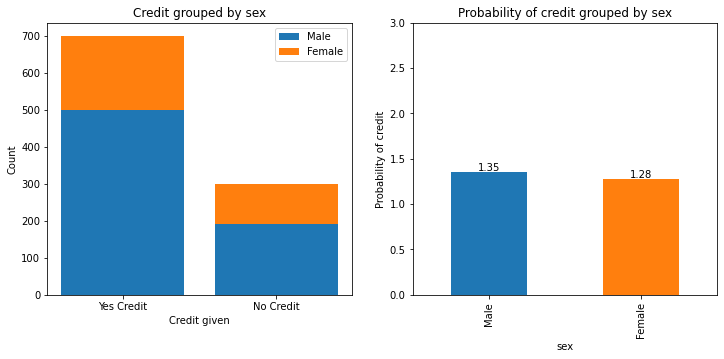

In [3]:
# Fairness-based exploratory data analysis

def analyze_fairness(dataset, data):
    # Separate income by group
    female = data[data['sex'] == 0]['credit'] # female == 0
    male = data[data['sex'] == 1]['credit'] # male == 1
    # Dataset metrics
    dm = BinaryLabelDatasetMetric(dataset, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    print('Base rate on entire population: {:.2f}'.format(dm.base_rate())) # privileged = None
    print('Base rate on privileged group (males) :{:.2f}'.format(dm.base_rate(privileged=True)))
    print('Base rate on unprivileged group (females) :{:.2f}'.format(dm.base_rate(privileged=False)))
    print('Statistical parity difference: {:.2f}'.format(dm.mean_difference()))
    print('Disparate impact: {:.2f}'.format(dm.disparate_impact()))
    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) # [1 x 2] grid
    ax1.bar(['Yes Credit', 'No Credit'], male.value_counts(), label='Male')
    ax1.bar(['Yes Credit', 'No Credit'], female.value_counts(), bottom=male.value_counts(), label='Female')
    ax1.set_xlabel('Credit given')
    ax1.set_ylabel('Count')
    ax1.set_title('Credit grouped by sex')
    ax1.legend()
    ax2_y = data.groupby('sex')['credit'].mean().sort_values(ascending=False)
    ax2_y.plot.bar(x=['Male', 'Female'], color=['#1f77b4', '#ff7f0e'], ylim=[0, 3])
    ax2.set_ylabel('Probability of credit')
    ax2.set_title('Probability of credit grouped by sex')
    ax2.set_xticklabels(['Male', 'Female'])
    for i, v in enumerate(ax2_y):
        ax2.text(i-0.07, v+0.02, '{:.2f}'.format(v))
    plt.show()

# Convert dataset to dataframe
german_df, _ = german.convert_to_dataframe()
# Call function
analyze_fairness(german, german_df)

In [4]:
# Train test split
train, test = dataset_orig.split([0.7], shuffle=True)
print("Training data size", train.features.shape)
protected_idx = train.feature_names.index(protected)

#Normalize the dataset, both train and test. This should always be done in any machine learning pipeline!
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scale_orig.transform(test.features) 
y_test = test.labels.ravel()

Training data size (700, 11)


# TASK 1

### 5 FOLD CROSS VALIDATION

In [5]:
# Defining parameter range of GridSearchCV
parameters ={'solver': ['newton-cg','lbfgs','liblinear'],
               'max_iter':[200,500,1000,1500,2000]}
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, 
                    scoring=['accuracy', 'precision', 'recall','f1_macro'],
                    refit='accuracy', cv=5, verbose=5,error_score='raise')

# fitting the model for grid search
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print ('The best parameters for evaluation are as per following:')
print (grid.best_params_)
print("The accuracy of the best model is: %0.2f" % grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_iter=200, solver=newton-cg; accuracy: (test=0.707) f1_macro: (test=0.523) precision: (test=0.727) recall: (test=0.939) total time=   0.0s
[CV 2/5] END max_iter=200, solver=newton-cg; accuracy: (test=0.714) f1_macro: (test=0.497) precision: (test=0.722) recall: (test=0.970) total time=   0.0s
[CV 3/5] END max_iter=200, solver=newton-cg; accuracy: (test=0.707) f1_macro: (test=0.509) precision: (test=0.723) recall: (test=0.949) total time=   0.0s
[CV 4/5] END max_iter=200, solver=newton-cg; accuracy: (test=0.743) f1_macro: (test=0.575) precision: (test=0.744) recall: (test=0.970) total time=   0.0s
[CV 5/5] END max_iter=200, solver=newton-cg; accuracy: (test=0.707) f1_macro: (test=0.493) precision: (test=0.720) recall: (test=0.960) total time=   0.0s
[CV 1/5] END max_iter=200, solver=lbfgs; accuracy: (test=0.707) f1_macro: (test=0.523) precision: (test=0.727) recall: (test=0.939) total time=   0.0s
[CV 2/5] END 

[CV 4/5] END max_iter=1500, solver=lbfgs; accuracy: (test=0.743) f1_macro: (test=0.575) precision: (test=0.744) recall: (test=0.970) total time=   0.0s
[CV 5/5] END max_iter=1500, solver=lbfgs; accuracy: (test=0.707) f1_macro: (test=0.493) precision: (test=0.720) recall: (test=0.960) total time=   0.0s
[CV 1/5] END max_iter=1500, solver=liblinear; accuracy: (test=0.707) f1_macro: (test=0.523) precision: (test=0.727) recall: (test=0.939) total time=   0.0s
[CV 2/5] END max_iter=1500, solver=liblinear; accuracy: (test=0.714) f1_macro: (test=0.497) precision: (test=0.722) recall: (test=0.970) total time=   0.0s
[CV 3/5] END max_iter=1500, solver=liblinear; accuracy: (test=0.707) f1_macro: (test=0.509) precision: (test=0.723) recall: (test=0.949) total time=   0.0s
[CV 4/5] END max_iter=1500, solver=liblinear; accuracy: (test=0.750) f1_macro: (test=0.593) precision: (test=0.750) recall: (test=0.970) total time=   0.0s
[CV 5/5] END max_iter=1500, solver=liblinear; accuracy: (test=0.707) f1_

In [6]:
learner = LogisticRegression(max_iter=200, solver='liblinear')
learner.fit(X_train, y_train)

predictions = learner.predict(X_test)
print("Logistic Regression Accuracy: %0.2f" %(100 * accuracy_score(y_test,predictions)) + "%")
print("\nConfusion Matrix: \n", confusion_matrix(y_test, predictions))

Logistic Regression Accuracy: 68.33%

Confusion Matrix: 
 [[198   7]
 [ 88   7]]


In [7]:
test_pred = test.copy()
test_pred.labels = predictions


metric=ClassificationMetric(test,test_pred,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)

print("Statistical Parity Difference: %0.4f" % metric.statistical_parity_difference())
print("Equal opportunity difference:  %0.4f" % metric.equal_opportunity_difference())
print("Average of difference:         %0.4f" % metric.average_odds_difference())
print("Balanced accuracy:              %0.4f" % ((metric.true_positive_rate() + metric.true_negative_rate()) / 2))
print("Disparate Impact:               %0.4f" % metric.disparate_impact())

Statistical Parity Difference: -0.1320
Equal opportunity difference:  -0.0882
Average of difference:         -0.1535
Balanced accuracy:              0.5198
Disparate Impact:               0.8674


# TASK 2

In [8]:
# Metric scores
accuracy_list = [] # accuracy
spd_list = [] # statistical parity difference
di_list = []  # disparate impact
fprd_list = [] # false positive rate difference
fnrd_list = [] # false negative rate difference
errd_list = [] # error rate difference
tprd_list=[]

# Experiment with different repair levels
for level in tqdm(np.arange(0., 1.1, 0.1)):
    # Algorithms for bias removal
    di_remover = DisparateImpactRemover(repair_level=level, sensitive_attribute='sex')

    # Repaired versions of train and test dataset objects
    ad_train_rep = di_remover.fit_transform(train)
    ad_test_rep = di_remover.fit_transform(test)

    # Construct X_train, X_test, y_train and y_test
    X_train = np.delete(ad_train_rep.features, protected_idx, axis=1)
    X_test = np.delete(ad_test_rep.features, protected_idx, axis=1)
    y_train = ad_train_rep.labels.ravel()
    y_test = ad_test_rep.labels.ravel()

    # Training and prediction
    learner.fit(X_train, y_train) # fit
    ad_test_rep_pred = ad_test_rep.copy() # need both dataset objects due to their different labels
    ad_test_rep_pred.labels = learner.predict(X_test) # prediction

    # Dataset metric
    dm = BinaryLabelDatasetMetric(ad_test_rep_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    di_list.append(dm.disparate_impact())
    # Classification metric
    cm = ClassificationMetric(ad_test_rep, ad_test_rep_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    # Metric calculations
    accuracy_list.append(cm.accuracy())
    fprd_list.append(cm.false_positive_rate_difference())
    fnrd_list.append(cm.false_negative_rate_difference())
    errd_list.append(cm.error_rate_difference())
    tprd_list.append(cm.true_positive_rate_difference())
    spd_list.append(cm.mean_difference())

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.15it/s]


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


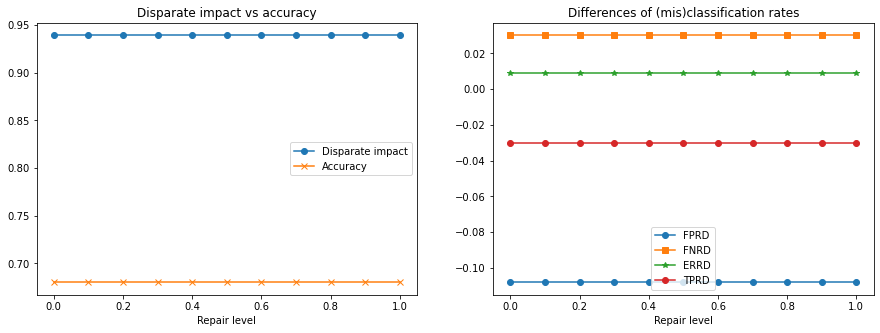

In [9]:
# Visualization of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # [1 x 2] grid
ax1.plot(np.arange(0., 1.1, 0.1), di_list, marker='o')
ax1.plot(np.arange(0., 1.1, 0.1), accuracy_list, marker='x')
ax1.set_xlabel('Repair level')
ax1.legend(['Disparate impact', 'Accuracy'])
ax1.set_title('Disparate impact vs accuracy')
ax2.plot(np.arange(0., 1.1, 0.1), fprd_list, marker='o')
ax2.plot(np.arange(0., 1.1, 0.1), fnrd_list, marker='s')
ax2.plot(np.arange(0., 1.1, 0.1), errd_list, marker='*')
ax2.plot(np.arange(0., 1.1, 0.1), tprd_list, marker='o')
ax2.set_xlabel('Repair level')
ax2.legend(['FPRD', 'FNRD', 'ERRD', 'TPRD'])
ax2.set_title('Differences of (mis)classification rates')
plt.show()

No change is observed in the graphs. This is because changing the repair level isn't causing a change in the disparate impact. But the disparate impact is pretty good at nearly 0.94. A Disparate Impact value close to 1 means that the bias is not much.

Base rate on entire population: 0.92
Base rate on privileged group (males) :0.94
Base rate on unprivileged group (females) :0.88
Statistical parity difference: -0.06
Disparate impact: 0.94


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


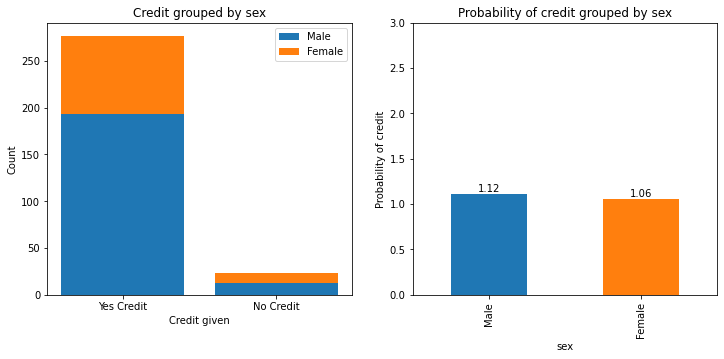

In [10]:
# Visualize bias in repaired test set

# Create dataframe from test set
sex = ad_test_rep_pred.features[:,protected_idx]
inc = ad_test_rep_pred.labels
ad_test_rep_pred_df = pd.DataFrame({'sex':sex, 'credit':inc})
# Call fairness analysis function
analyze_fairness(ad_test_rep_pred, ad_test_rep_pred_df)

# TASK 3

In [ ]:
model_1 = learner.fit(X_train,y_train)
report.compare(X_test, y_test, X_train['sex'], model_1, pred_type="regression")